Capital One 2019 Data breach announced on July 29th

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import statsmodels.formula.api as smf
from yahoo_fin import stock_info as si
import yfinance as yf

In [2]:
def get_daily_prices(ticker, start_date, end_date):
    df = si.get_data(ticker, interval='1d', start_date=start_date, end_date=end_date)
    df['price'] = df['adjclose']
    df['date'] = df.index
    df['ticker'] = ticker
    df = df[['date', 'price', 'ticker']]
    return df

def get_prices(tickerlist, start, end):
    df = pd.DataFrame(columns=['date', 'price', 'ticker'])
    for ticker in tickerlist:
        df = pd.concat([df, get_daily_prices(ticker, start, end)], ignore_index=True)
    return df

def run_diff_in_diff(df, event_date, treated):
    start_date = event_date - datetime.timedelta(days=180)
    df = df[(df['date'] >= start_date) & (df['date'] <= event_date)].copy()
    
    df['returns'] = df.groupby('ticker')['price'].pct_change()
    df = df.dropna(subset=['returns'])  # Drop rows where 'returns' is NaN

    df.loc[:, 'treated'] = np.where(df['ticker'] == treated, 1, 0)
    df.loc[:, 'post'] = np.where(df['date'] >= event_date, 1, 0)
    df.loc[:, 'treated_post'] = df['treated'] * df['post']
    
    formula = "returns ~ treated + post + treated_post"
    model = smf.ols(formula=formula, data=df).fit()
    return model

def difference_in_trends(df, event_date, treated):
    start_date = event_date - datetime.timedelta(days=180)
    df = df[(df['date'] >= start_date) & (df['date'] <= event_date)].copy()
    
    # Create the 'returns' column
    df['returns'] = df.groupby('ticker')['price'].pct_change()
    df = df.dropna(subset=['returns'])  # Drop rows where 'returns' is NaN

    df.loc[:, 'treated'] = np.where(df['ticker'] == treated, 1, 0)
    df.loc[:, 'trend'] = (event_date - df['date']).dt.days
    df.loc[:, 'treated_trend'] = df['treated'] * df['trend']
    
    formula = "returns ~ treated + trend + treated_trend"
    model = smf.ols(formula=formula, data=df).fit()
    return model

In [3]:
start_date = '01-01-2019'
end_date = '08-19-2019'
event_date = pd.to_datetime('07-30-2019')

tickerlist = list(['COF', 'SPY', 'VTI', 'BAC', 'USB', 'C', 'JPM', 'WFC'])
prices = get_prices(tickerlist, start_date, end_date)
prices['return'] = np.where(prices['ticker'] == prices['ticker'].shift(), 
                            prices['price'] / prices['price'].shift() - 1, 
                            np.nan)

prices.dropna(subset=['return'], inplace=True)
prices['date'] = pd.to_datetime(prices['date'])

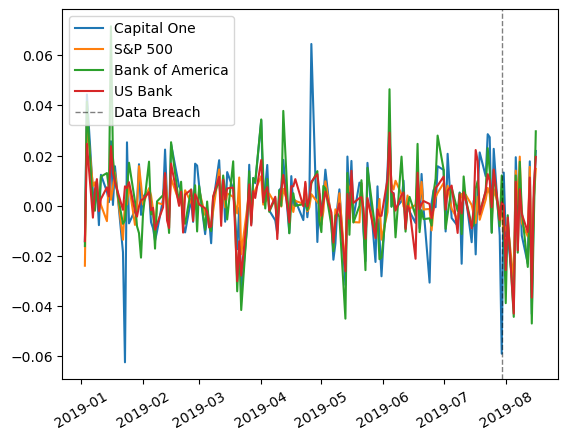

In [4]:
prices['returns'] = np.where(prices['ticker'] == prices['ticker'].shift(), 
                            prices['price'] / prices['price'].shift() - 1, 
                            np.nan)
eventDate = pd.to_datetime('07-30-2019')

cof=prices[prices['ticker']=='COF']
spy=prices[prices['ticker']=='SPY']
bac=prices[prices['ticker']=='BAC']
usb=prices[prices['ticker']=='USB']

plt.plot(cof['date'], cof['return'], label='Capital One')
plt.plot(spy['date'], spy['return'], label='S&P 500')
plt.plot(bac['date'], bac['return'], label='Bank of America')
plt.plot(usb['date'], usb['return'], label='US Bank')
plt.axvline(eventDate, color='black', linestyle='--', linewidth=1, alpha=.5, label = 'Data Breach')
plt.xticks(rotation=30)
plt.legend(loc="upper left")
plt.show()

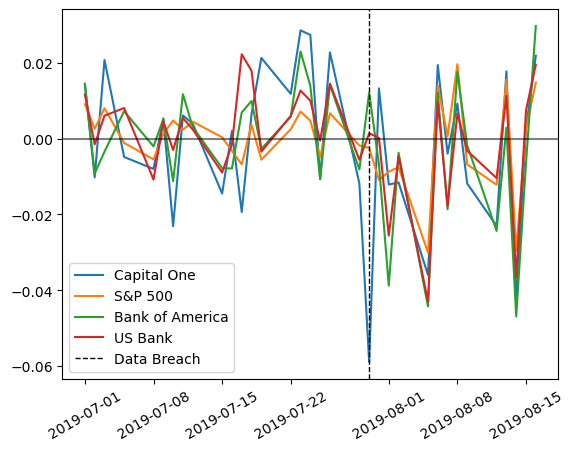

In [5]:
prices['returns'] = np.where(prices['ticker'] == prices['ticker'].shift(), 
                            prices['price'] / prices['price'].shift() - 1, 
                            np.nan)
eventDate = pd.to_datetime('07-30-2019')

prices['date'] = pd.to_datetime(prices['date'])
focused_prices = prices[(prices['date'] >= pd.to_datetime('07-01-2019')) & (prices['date'] <= pd.to_datetime('08-30-2019'))]

cof=focused_prices[focused_prices['ticker']=='COF']
spy=focused_prices[focused_prices['ticker']=='SPY']
bac=focused_prices[focused_prices['ticker']=='BAC']
usb=focused_prices[focused_prices['ticker']=='USB']

plt.plot(cof['date'], cof['return'], label='Capital One')
plt.plot(spy['date'], spy['return'], label='S&P 500')
plt.plot(bac['date'], bac['return'], label='Bank of America')
plt.plot(usb['date'], usb['return'], label='US Bank')
plt.axhline(y=0, color='black', alpha=.5)
plt.axvline(eventDate, color='black', linestyle='--', linewidth=1, label = 'Data Breach')
plt.xticks(rotation=30)
plt.legend(loc="lower left")
plt.show()

In [6]:
prices[prices['date']>='07-25-2019'].iloc[:10]

,date,price,ticker,return,returns
141,2019-07-25,87.911079,COF,-0.010524,-0.010524
142,2019-07-26,89.909462,COF,0.022732,0.022732
143,2019-07-29,88.846100,COF,-0.011827,-0.011827
144,2019-07-30,83.611786,COF,-0.058914,-0.058914
145,2019-07-31,84.720993,COF,0.013266,0.013266
146,2019-08-01,83.694283,COF,-0.012119,-0.012119
147,2019-08-02,82.727524,COF,-0.011551,-0.011551
148,2019-08-05,79.753555,COF,-0.035949,-0.035949
149,2019-08-06,81.300400,COF,0.019395,0.019395
150,2019-08-07,80.978127,COF,-0.003964,-0.003964


# Estimate Difference-in-Differences Model

In [7]:
treated = 'COF'
model = run_diff_in_diff(prices, event_date, treated)
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                returns   R-squared:                       0.028
Model:                            OLS   Adj. R-squared:                  0.025
Method:                 Least Squares   F-statistic:                     9.428
Date:                Sat, 15 Jun 2024   Prob (F-statistic):           3.81e-06
Time:                        12:04:17   Log-Likelihood:                 3034.8
No. Observations:                 992   AIC:                            -6062.
Df Residuals:                     988   BIC:                            -6042.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        0.0009      0.000      2.202   

The -0.0616 treated post indicates the event is resposible for about a 6% drop in market price

# Test Validation Assumptions

##### Assumption 1: There is no difference in trend prior to the event

In [8]:
placebo_date = event_date - datetime.timedelta(days=1)
treated='COF'

test_trend_model = difference_in_trends(prices, placebo_date, treated)
print(test_trend_model.summary())

                            OLS Regression Results                            
Dep. Variable:                returns   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.7367
Date:                Sat, 15 Jun 2024   Prob (F-statistic):              0.530
Time:                        12:04:18   Log-Likelihood:                 3032.5
No. Observations:                 992   AIC:                            -6057.
Df Residuals:                     988   BIC:                            -6037.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         0.0016      0.001      2.128

Here the treated trend value is extremely close to 0 and even has a p-value of 0.85 so it is not even close to statistically significant. ie. In the pre period there is no real difference in trend  and so no reason to believe that it would change afterwards

##### Assumption 2: The model is not biased (estimates close to zero when no effect)

In [9]:
placebo_date = event_date - datetime.timedelta(days=1)
treated='COF'

placebo_model = run_diff_in_diff(prices, placebo_date, treated)
print(placebo_model.summary())

                            OLS Regression Results                            
Dep. Variable:                returns   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     1.700
Date:                Sat, 15 Jun 2024   Prob (F-statistic):              0.165
Time:                        12:04:18   Log-Likelihood:                 3034.0
No. Observations:                 992   AIC:                            -6060.
Df Residuals:                     988   BIC:                            -6040.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        0.0009      0.000      2.281   

Again we get a treated post near 0 and a p value still no where near .05 and so not stastically significant

In [10]:
placebo_start = event_date - datetime.timedelta(days=120)
pre_event_dates = prices[(prices['date'] >= placebo_start) & (prices['date'] < event_date)]['date']
pvalues = list()
betas = list()

for placebo_date in pre_event_dates:
    placebo_model=run_diff_in_diff(prices, pd.to_datetime(placebo_date), treated)
    pvalues.append(placebo_model.pvalues['treated_post'])
    betas.append(placebo_model.params['treated_post'])

In [11]:
df = pd.DataFrame({'betas':betas, 'pvalues':pvalues})
print(display(df.describe()))

,betas,pvalues
count,664.000000,664.000000
mean,0.000692,0.646151
std,0.010636,0.261996
min,-0.025293,0.000011
25%,-0.004635,0.486030
50%,0.000642,0.720415
75%,0.005038,0.860783
max,0.056549,0.998293


None


In [12]:
#Not Working
print("Share of pvalue < 0.5: {:.2f}%".format(100 * len(df[df['pvalues'] < 0.5]) / len(df)))

Share of pvalue < 0.5: 27.71%


In [13]:
df['betas'].quantile([0.025,0.975])

0.025   -0.019087
0.975    0.016195
Name: betas, dtype: float64

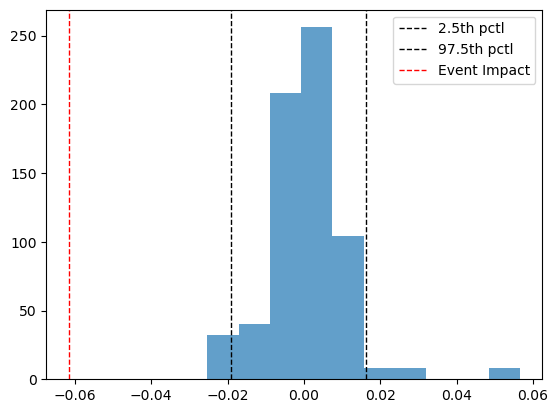

In [14]:
quantile_2_5 = df['betas'].quantile(0.035)
quantile_97_5 = df['betas'].quantile(0.975)
model_est = model.params['treated_post']

plt.hist(df['betas'], bins=10, alpha=0.7)
plt.axvline(quantile_2_5, color='black', linestyle='--', linewidth=1, label = '2.5th pctl')
plt.axvline(quantile_97_5, color='black', linestyle='--', linewidth=1, label = '97.5th pctl')
plt.axvline(model_est, color='red', linestyle='--', linewidth=1, label = 'Event Impact')
plt.legend(loc='upper right')
plt.show()

In [15]:

tickers = yf.Tickers("COF BAC USB C JPM WFC")

cofEarnings = tickers.tickers['COF'].get_earnings_dates(limit=50)
bacEarnings = tickers.tickers['BAC'].get_earnings_dates(limit=150)
usbEarnings = tickers.tickers['USB'].get_earnings_dates(limit=60)
cEarnings = tickers.tickers['C'].get_earnings_dates(limit=85)
jpmEarnings = tickers.tickers['JPM'].get_earnings_dates(limit=137)
wfcEarnings = tickers.tickers['WFC'].get_earnings_dates(limit=75)

earningsList = [cofEarnings, bacEarnings, usbEarnings, cEarnings, jpmEarnings, wfcEarnings]

for company in earningsList:
    company.dropna(inplace=True)
    company.index = company.index.date
    company.drop_duplicates(inplace=True)
    company['Date'] = company.index
    company.reset_index(inplace=True)
    company.drop(columns=["index"], inplace=True)
    company['Date']=pd.to_datetime(company['Date'])
    company['Month'] = company['Date'].dt.to_period('M')
    company.drop('Date', axis=1, inplace=True)
    company['Month'] = company['Month'].dt.to_timestamp()

    
common_months = set(wfcEarnings['Month'])
for earnings in earningsList[1:]:
    common_months &= set(earnings['Month'])

filtered_earnings = []
for earnings in earningsList:
    filtered_earnings.append(earnings[earnings['Month'].isin(common_months)])
    
cofEarnings, bacEarnings, usbEarnings, cEarnings, jpmEarnings, wfcEarnings = filtered_earnings

jpmEarnings

,EPS Estimate,Reported EPS,Surprise(%),Month
1,4.11,4.44,0.0792,2024-04-01
2,3.06,2.80,-0.0850,2024-03-01
3,3.32,3.04,-0.0850,2024-01-01
4,3.96,4.50,0.1371,2023-10-01
5,4.00,4.98,0.2465,2023-07-01
6,3.41,4.32,0.2664,2023-04-01
7,3.07,3.56,0.1614,2023-01-01
8,2.88,3.36,0.1656,2022-10-01
9,2.88,2.76,-0.0425,2022-07-01
10,2.69,2.76,0.0267,2022-04-01


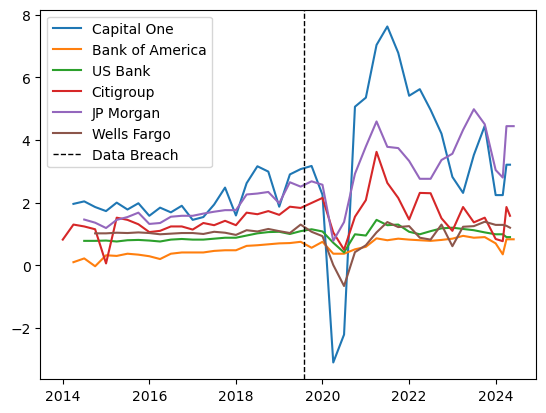

In [16]:
companies = ['Capital One', 'Bank of America', 'US Bank', 'Citigroup', 'JP Morgan', 'Wells Fargo']
eventDate = pd.to_datetime('07-30-2019')



for index, company in enumerate(earningsList):
    plt.plot(company['Month'], company['Reported EPS'], label = companies[index])
plt.axvline(eventDate, color='black', linestyle='--', linewidth=1, label = 'Data Breach')
plt.legend()
plt.show()